In [1]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:12<00:00, 109MB/s]
100% 2.29G/2.29G [00:12<00:00, 201MB/s]


In [6]:
! unzip chest-xray-pneumonia

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [7]:
#import libraries
import numpy as np
import glob
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
random.seed(42)

In [8]:
#create path to photos and load data
directory = '/content/chest_xray/chest_xray'

sets = ["train", "test", "val"]

all_normal = []
all_pneumonia = []

for cat in sets:
    path = os.path.join(directory, cat)
    normal = glob.glob(os.path.join(path, 'NORMAL/*.jpeg'))
    pneumonia = glob.glob(os.path.join(path, 'PNEUMONIA/*.jpeg'))
    all_normal.extend(normal)
    all_pneumonia.extend(pneumonia)

print(f'{len(all_pneumonia)} Pneumonia Images')
print(f'{len(all_normal)} Normal Images')

4273 Pneumonia Images
1583 Normal Images


        Case  Number
0     Normal    4273
1  Pneumonia    1583


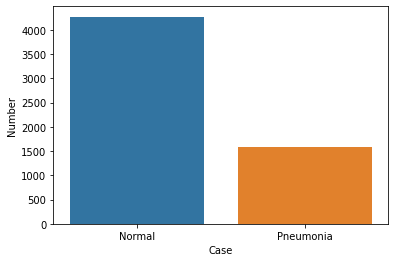

In [9]:
#create distribution plot
labels = ['Normal', 'Pneumonia'] 
cases = [len(all_pneumonia), len(all_normal)]
plot_data = {'Case' : labels, 'Number' : cases}

plot_df = pd.DataFrame(data=plot_data)
print(plot_df)
count_plot = sns.barplot(x= 'Case', y = 'Number', data= plot_df)

In [10]:
random.shuffle(all_normal)
random.shuffle(all_pneumonia)
images = all_normal[:50] + all_pneumonia[:50]

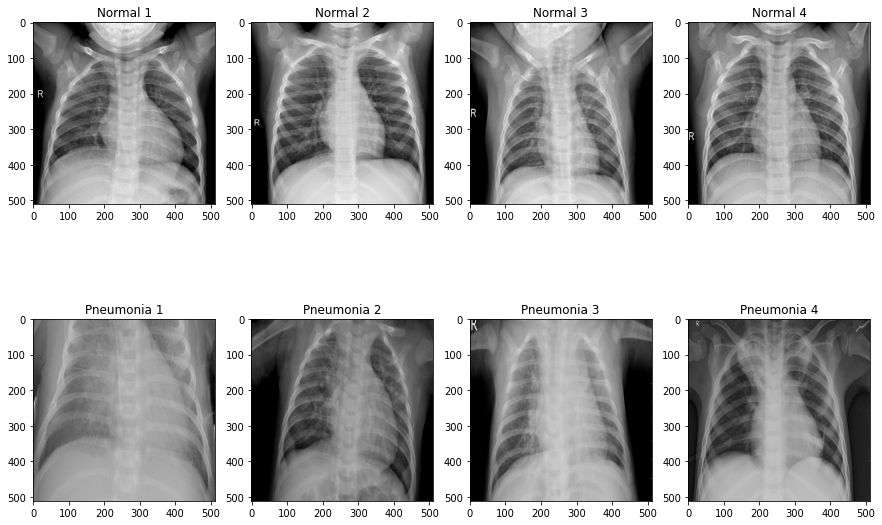

In [11]:
#show a few examples photos both normal and pneumonia cases
fig=plt.figure(figsize=(15, 10))
ax = []
columns = 4; rows = 2
for i in range(rows*columns):
    if i < columns:
        img = cv2.imread(all_normal[i])
        img = cv2.resize(img, (512, 512))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.append( fig.add_subplot(rows, columns, i+1) )
        ax[i].set_title("Normal "+str(i+1))  # set title
    else:
        img = cv2.imread(all_pneumonia[i-columns])
        img = cv2.resize(img, (512, 512))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.append( fig.add_subplot(rows, columns, i+1) )
        ax[i].set_title("Pneumonia "+str(i-columns+1))  # set title
        
    plt.imshow(img)
i=0

In [12]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)


In [13]:
train = get_training_data('/content/chest_xray/chest_xray/train')
test = get_training_data('/content/chest_xray/chest_xray/test')
val = get_training_data('/content/chest_xray/chest_xray/val')


OpenCV(4.6.0) /io/opencv/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.6.0) /io/opencv/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  from ipykernel import kernelapp as app


OpenCV(4.6.0) /io/opencv/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.6.0) /io/opencv/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



In [14]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [15]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

# resize data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [16]:
datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False, 
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range = 30,  
        zoom_range = 0.2, 
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip = True, 
        vertical_flip=False) 


datagen.fit(x_train)


In [17]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 75, 75, 64)       2

In [18]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [19]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 12 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

Epoch 1/12
163/163 [==============================] - 31s 94ms/step - loss: 0.5921 - accuracy: 0.8342 - val_loss: 30.0939 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/12
163/163 [==============================] - 13s 81ms/step - loss: 0.2631 - accuracy: 0.9043 - val_loss: 59.4532 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/12
163/163 [==============================] - ETA: 0s - loss: 0.2241 - accuracy: 0.9227
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 11s 66ms/step - loss: 0.2241 - accuracy: 0.9227 - val_loss: 34.2150 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/12
163/163 [==============================] - 11s 68ms/step - loss: 0.1402 - accuracy: 0.9494 - val_loss: 5.6729 - val_accuracy: 0.5000 - lr: 3.0000e-04
Epoch 5/12
163/163 [==============================] - 11s 68ms/step - loss: 0.1372 - accuracy: 0.9526 - val_loss: 0.6875 - val_accuracy: 0.8125 - lr: 3.0000e-04
Epoch 6/12
163/163 [=======================

In [20]:
print("Loss: " , model.evaluate(x_test,y_test)[0])
print("Accuracy: " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 1s 13ms/step - loss: 0.2615 - accuracy: 0.9119
Loss:  0.261464923620224
20/20 [==============================] - 0s 13ms/step - loss: 0.2615 - accuracy: 0.9119
Accuracy:  91.18589758872986 %


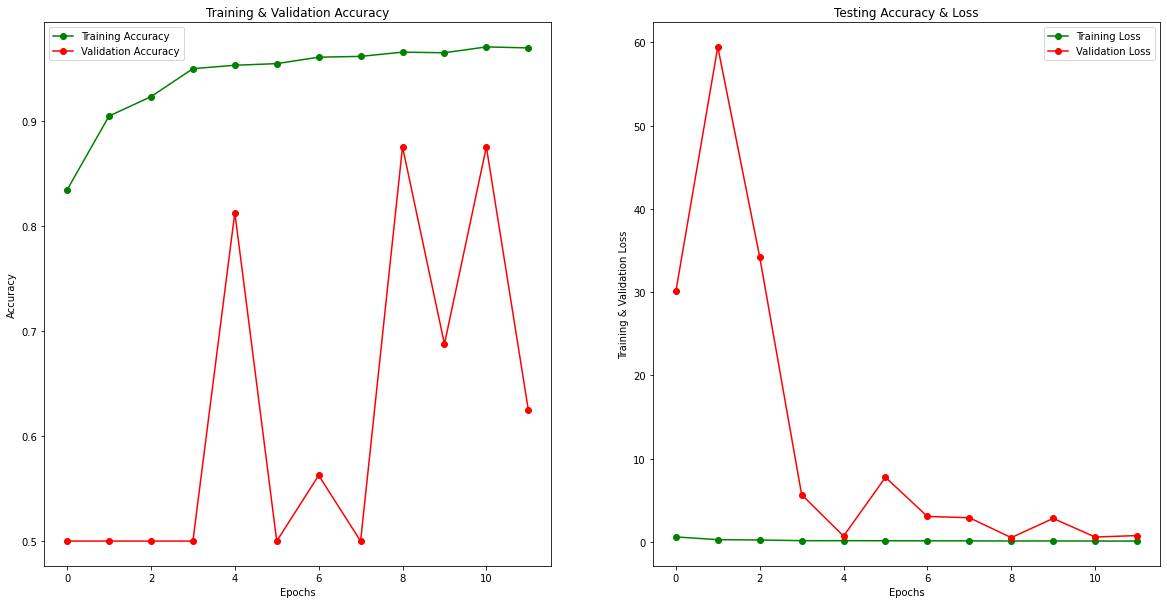

In [21]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

plt.show()